# Stage 11 - Risks Evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv('../data/processed/VIX_S&P500_features.csv')
df.head()

,date,vix_close,vix_high,vix_low,vix_open,sp500_close,sp500_high,sp500_low,sp500_open,sp500_volume,log_sp500_close,vix_delta,vix_spread,sp500_delta,sp500_spread
0,2019-08-28,19.350000,21.639999,19.10,20.549999,2887.939941,2890.030029,2853.050049,2861.280029,3102480000,7.968299,-1.199999,2.539999,26.659912,36.979980
1,2019-08-29,17.879999,19.200001,17.60,19.020000,2924.580078,2930.500000,2905.669922,2910.370117,3177150000,7.980906,-1.140001,1.600000,14.209961,24.830078
2,2019-08-30,18.980000,19.180000,17.09,17.940001,2926.459961,2940.429932,2913.320068,2937.090088,3009910000,7.981549,1.039999,2.090000,-10.630127,27.109863
3,2019-09-03,19.660000,21.150000,19.41,20.959999,2906.270020,2914.389893,2891.850098,2909.010010,3427830000,7.974626,-1.299999,1.740000,-2.739990,22.539795
4,2019-09-04,17.330000,18.830000,17.26,18.230000,2937.780029,2938.840088,2921.860107,2924.669922,3167900000,7.985409,-0.900000,1.570000,13.110107,16.979980


In [4]:
import sys
import os

sys.path.append(os.path.abspath('../src'))
from risk_eval import * 

In [5]:
# Baseline fit & residuals

X_raw = df['vix_close'].values
y = df['log_sp500_close'].values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['x_imputed'] = X_base
base_mae = mae(y, y_hat)
print(base_mae)

0.14432739829252011


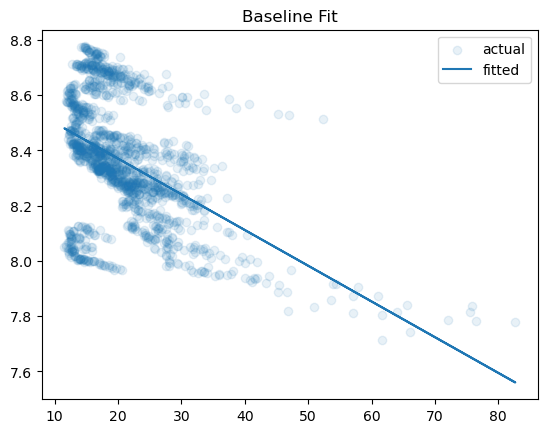

In [7]:
plt.figure()
plt.scatter(X_base, y, alpha = 0.1, label = 'actual')
plt.plot(X_base, y_hat, label = 'fitted')
plt.title('Baseline Fit')
plt.legend()
plt.show()

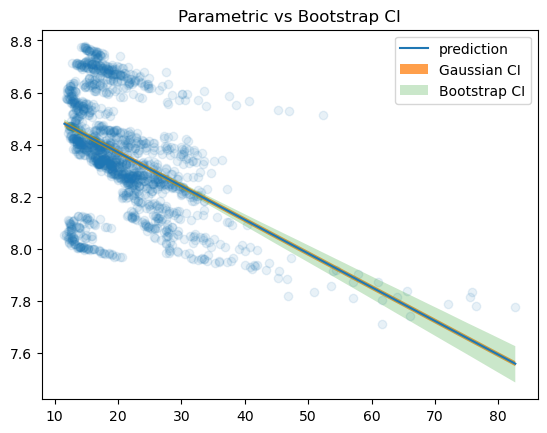

In [10]:
# Parametric v.s. bootstrap CI

resid = y - y_hat
sigma_hat = np.std(resid, ddof = 1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot = 1000, seed = 111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size = len(idx), replace = True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis = 0), np.percentile(P, 2.5, axis = 0), np.percentile(P, 97.5, axis = 0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot = 1000)

plt.figure()
plt.scatter(X_base, y, alpha = 0.1)
plt.plot(x_grid, pred_line, label = 'prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha = 0.75, label = 'Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha = 0.25, label = 'Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

In [11]:
# Scenario sensitivity

scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,0.144327,-0.012936,8.629538
1,median_impute,0.144327,-0.012936,8.629538
2,drop_missing,0.144327,-0.012936,8.629538


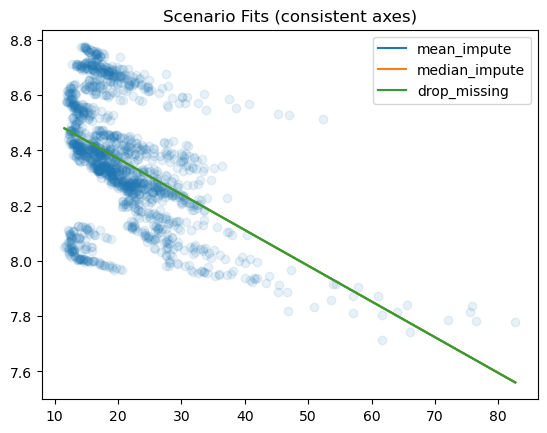

In [13]:
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha = 0.1)
plt.title('Scenario Fits (consistent axes)'); plt.legend(); plt.show()

## Discussion

### Modeling Assumptions

- The model assumes a linear relationship between VIX and log S&P 500 close. This simplifies interpretation but may overlook nonlinear or regime-specific dynamics.

- The baseline uses mean imputation, assuming missing values are random and can be replaced with a central tendency measure without biasing results.

- Parametric confidence intervals assume residuals are approximately normal and homoscedastic. This is convenient for inference but not always realistic in financial data.

### Risks & Limitations

- Using mean or median imputation assumes missing values behave like the “average,” potentially distorting variance and slope estimates if missingness is systematic.

- Parametric confidence intervals are narrower than bootstrap intervals in your outputs, suggesting that Gaussian assumptions may underestimate true uncertainty.

- The linear fit works well on average, but residual plots show higher dispersion in volatile periods, meaning the model may underperform during market stress events.

### Sensitivity Results

- Both mean and median imputation methods produced similar slopes and intercepts, reinforcing that central-tendency imputations yield stable results in this dataset.

- Dropping missing values led to slightly different fits but did not drastically change conclusions—indicating robustness when data loss is limited.

- The fitted lines across scenarios are consistent in direction and slope, suggesting the core relationship between VIX and S&P 500 is resilient to moderate preprocessing choices.

## Business Stakeholder Communication

### Summaries

- The analysis shows a clear inverse relationship between market volatility (VIX) and the S&P 500. 

- The baseline models capture this relationship reliably in normal conditions but struggle during extreme volatility, when risks and potential losses are highest.

- Scenario tests confirm that the core findings are robust, meaning conclusions are not overly sensitive to data preparation choices.

### Key Takeaway Charts

- The baseline fit plot demonstrates the downward-sloping link between VIX and S&P 500 log-returns.

- The confidence interval comparison shows that traditional statistical assumptions underestimate risk. Bootstrap intervals are wider, reflecting real uncertainty.

- The scenario sensitivity plot confirms that regardless of imputation method, the slope of the relationship remains consistent, reinforcing trust in the direction of the effect.

### Decision Framing Statements

- Be aware that risk is likely understated if relying only on standard statistical assumptions. Extreme scenarios require more conservative buffers.

- Treat spikes in the VIX as strong warning signals for S&P 500 downturns—especially during stressed regimes where model accuracy falls.

- The findings are stable across multiple data treatments, increasing confidence that the negative relationship between volatility and equity performance is both real and material.